In [12]:
def _plot_tick_bars(timestamps_i, ax, color):
    for t in timestamps_i:
        ax.axvline(x=t, color = color)
    # ax.set_title(label, fontsize=20)
    ax.get_yaxis().set_visible(False)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_points = 30 # Number of time points
time = np.arange(n_points)

# Generate base binary time series using Bernoulli distribution
X1 = np.random.binomial(1, 0.6, n_points)
X2 = np.zeros(n_points)
X3 = np.zeros(n_points)

# Introduce causal relationships
for t in range(1, n_points):
    # X2 is more likely to happen if X1 happened in the previous step
    X2[t] = np.random.binomial(1, 0.7 * X1[t-1] + 0.1)
    # X3 is more likely to happen if X2 happened in the previous step
    X3[t] = np.random.binomial(1, 0.8 * X2[t-1] + 0.1)


print(X1)

X1 = [time[i] for i in range(len(X1)) if X1[i] > 0]
X2 = [time[i] + 0.1 for i in range(len(X2)) if X2[i] > 0]
X3 = [time[i] + 0.3 for i in range(len(X3)) if X3[i] > 0]

[1 0 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1]


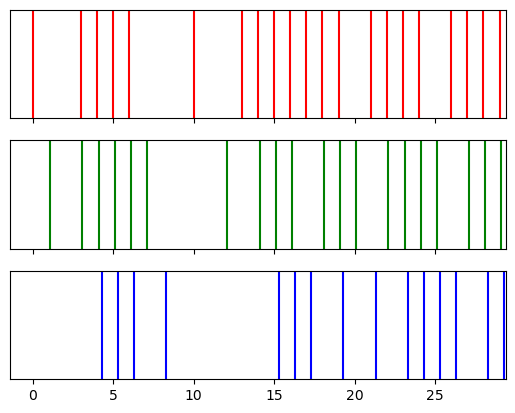

In [14]:
fig, ax = plt.subplots(nrows = 3, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    device = "cuda"
else:
    torch.set_default_tensor_type("torch.FloatTensor")
    device = "cpu"
    

In [16]:
def get_inter_times(t : torch.Tensor, t_end : int):
    # t.sort()

    t = t.cpu().numpy()
    tau = np.diff(t, prepend = 0, append=t_end)
    
    return torch.tensor(tau, dtype=torch.float32, device=device)

In [17]:
X1_ = torch.tensor(X1.copy(), dtype = torch.float32)
X2_ = torch.tensor(X2.copy(), dtype = torch.float32)
X3_ = torch.tensor(X3.copy(), dtype = torch.float32)
processes = [X1_, X2_, X3_]

seq_lengths = [len(t) for t in processes]

t_end_scalar = 30
t_end = [t_end_scalar]*len(processes)

taus = list(map(lambda p: get_inter_times(*p), zip(processes, t_end)))
taus = [taus[i] for i in range(3)]

padded_taus = pad_sequence(taus, batch_first=True)  # (B, L)
padded_taus[-1].cumsum(dim = 0)

tensor([ 4.3000,  5.3000,  6.3000,  8.3000, 15.3000, 16.3000, 17.3000, 19.3000,
        21.3000, 23.3000, 24.3000, 25.3000, 26.3000, 28.3000, 29.3000, 30.0000,
        30.0000, 30.0000, 30.0000, 30.0000, 30.0000, 30.0000])

In [18]:
from MAF_All_in_One import maf_dsf

In [19]:
# F.gumbel_softmax?

In [20]:
# from torch import vmap

In [21]:
## processo A causou tempo 3, 7 e 9
## pega o tempo 3, 7 e 9
## computa a derivada do flow do processo A considerando apenas 3, 7 e 9

In [22]:
A = [1, 2, 3, 5]
B = [0.5, 3, 4, 10]
C = []

In [23]:
### focando no processo A, vamos supor que o pA tenha tempos [1, 9, 14]
### [1, 14] causado por B, e [9] por C

In [45]:
def sweep(pa, pc):
  events = []
  for ia in pa:
    events.append((ia, 'a'))
  for ic in pc:
    events.append((ic, 'c'))

  lim = 4

  events.sort()
  #print(events)
  mem = []
  ret = []
  for [t, e] in events:

    if e == 'c':
      if len(mem) >= lim:
        mem.pop(0)
      mem.append(t)

    if e == 'a':
      ## memoria ainda nao esta cheia:
      if len(mem) < lim:
        continue
      ## recupere os deltas desse tempo para o tempo causa
      pp = []
      for tc in mem:
        pp.append(t - tc)
      ret.append(pp)

  return ret


# s3 = sweep(p2, p3)
# s4 = sweep(p2, p4)

# for j, t in cur:
#   causa = causes[cur][j]
#   f = s[causa][j]

p1  = [1, 2.7, 4.8, 20, 21]
p2  = [0.5, 3, 8, 10] # 40 - 20 + 40 - 4.8 = 20 + 35.2 = 55.2
t = sweep(p1, p1)
t

[[20, 18.3, 16.2, 1]]

In [25]:
def make_sweep_tensor(processes):

    num_proc = len(processes)
    dic = {}
    for i in range(num_proc):
        target = processes[i]
        dic[i] = {}
        for j in range(num_proc):
            cause = processes[j]
            dic[i][j] = sweep(target, cause)
    return dic
    

In [26]:
sweep_tensor = make_sweep_tensor(processes)

In [27]:
# sweep_tensor

In [28]:
# sweep(processes[0], processes[0])

In [29]:
# s = F.gumbel_softmax(hard = True)

In [30]:
# def e_step(
#     in_weights: torch.Tensor,
#     points_current_pp: list[float]
# ):
    
#     """
#     Return the causes for each event of the current_p
    
#     """
    
#     n = len(points_current_pp)
#     rv = []

#     for i in range(n):
#         cause = F.gumbel_softmax(
#             in_weights,
#             hard = True
#         )
#         cause = torch.argmax(cause, dim = 0)
#         rv.append(cause)

    
    
#     return rv

# def em_step(
    
#     models: None, #nn.ModuleList,
#     Granger: torch.Tensor,
#     processes: list[list[float]]
# ):
#     n_proc = 3 
#     causes = []

#     for i_proc in range(n_proc):
#         rv = e_step(
#             Granger[i_proc],
#             processes[i_proc]
#         )
#         causes.append(rv)
    
    
#     for i_proc in range(n_proc):
        
#         causes_to_ith = causes[i_proc] ## causes of ith_proc
#         model = models[i_proc]
        
#         for j, cause_to_ith in enumerate(causes_to_ith):
#             effect_j_on_i = sweep_tensor[i_proc][cause_to_ith]
#             if len(effect_j_on_i) < j:
#                 X_to_pass = effect_j_on_i[j]
#             else:
#                 continue
            

#     return 

In [31]:
# nn.Parameter(1,2)

In [34]:
class GrangerMPP(nn.Module):

    def __init__(self, processes, memory_dim : int = 4):
        
        super().__init__()
        
        self.processes = processes
        self.memory_dim = memory_dim
        self.n_processes = len(self.processes)
        self.GrangerMatrix = nn.Parameter(nn.Softmax(dim = 1)(nn.Parameter(torch.Tensor(self.n_processes, self.n_processes))))
        self.models = nn.ModuleList([maf_dsf.MAF(p = memory_dim, flowtype = 'ddsf') for i in range(self.n_processes)])
        self.sweep_dict = self.make_sweep_dict()
        self.optimizers = [torch.optim.Adam(list(self.models[i].parameters()) + [self.GrangerMatrix], lr=1e-4) for i in range(self.n_processes)]

    def e_step(self, in_weights: torch.Tensor, points_current_pp):

        
        """
        Return the causes for each event of the current_p
        
        """
        
        n = len(points_current_pp)
        rv = []
    
        for i in range(n):
            cause = F.gumbel_softmax(
                in_weights,
                hard = True
            )
            cause = torch.argmax(cause, dim = 0)
            rv.append(cause)
    
        
        
        return rv

    def em_step(self, n_steps):
        dic = {}
        
        for i in range(self.n_processes):
            dic[i] = []
        
        for step in range(n_steps):
            self.causes = []
            for i_proc in range(self.n_processes):
                rv = self.e_step(
                    self.GrangerMatrix[i_proc],
                    self.processes[i_proc]
                )
                self.causes.append(rv)
            
            
            for i_proc in range(self.n_processes):
                
                causes_to_ith = self.causes[i_proc] ## causes of ith_proc
                
                for j, cause_to_ith in enumerate(causes_to_ith):
                    
                    cause_to_ith = cause_to_ith.item()
                    effect_j_on_i = self.sweep_dict[i_proc][cause_to_ith]
                    
                    if (cause_to_ith == i_proc) and j>=4:
                        X_to_pass = processes[i_proc][j - 4 : j]
                        X_to_pass = X_to_pass.flip(dims = (0,)) - X_to_pass[0]
                        loss = self.m_step(i_proc, X_to_pass.unsqueeze(0)) 
                        dic[i_proc].append(loss)
                    
                    elif len(effect_j_on_i) > j:
                        X_to_pass = effect_j_on_i[j]
                        loss = self.m_step(i_proc, X_to_pass.unsqueeze(0))
                        dic[i_proc].append(loss)
                
                if (step + 1) % 25 == 0 or step == 0:
                                print(f'Step: {step + 1}, Model: {i_proc}, Loss: {loss}')
                    
    
        return dic

    def m_step(self, i_proc, X):
        model = self.models[i_proc]
        self.optimizers[i_proc].zero_grad()
        
        z, loss = model.density(X)
        
        if not (torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            self.optimizers[i_proc].step()
        else:
            print(f'NaN found in epoch: {step}')    

        return loss.item()

    def make_sweep_dict(self):
        
        dic = {}
        for i in range(self.n_processes):
            target = processes[i]
            dic[i] = {}
            for j in range(self.n_processes):
                cause = self.processes[j]
                dic[i][j] = self.sweep(target, cause)
        return dic


    def sweep(self, pa, pc):
      events = []
      for ia in pa:
        events.append((ia, 'a'))
      for ic in pc:
        events.append((ic, 'c'))
    
      lim = 4
    
      events.sort()
      mem = []
      ret = []
      for [t, e] in events:
    
        if e == 'c':
          if len(mem) >= lim:
            mem.pop(0)
          mem.append(t)
    
        if e == 'a':
          ## memoria ainda nao esta cheia:
          if len(mem) < lim:
            continue
          ## recupere os deltas desse tempo para o tempo causa
          pp = []
          for tc in mem:
            pp.append(t - tc)
          ret.append(pp)
    
      return torch.tensor(ret, dtype = torch.float)

In [35]:
s = GrangerMPP(processes)
l = s.em_step(n_steps = 50)

Step: 1, Model: 0, Loss: 9.11256217956543
Step: 1, Model: 1, Loss: 7.8895063400268555
Step: 1, Model: 2, Loss: 9.177583694458008
Step: 25, Model: 0, Loss: 8.440007209777832
Step: 25, Model: 1, Loss: 7.507286548614502
Step: 25, Model: 2, Loss: 7.7635498046875
Step: 50, Model: 0, Loss: 7.7686448097229
Step: 50, Model: 1, Loss: 7.437277793884277
Step: 50, Model: 2, Loss: 7.17104959487915


In [36]:
# fig, ax = plt.subplots(nrows = 3, sharex = True)

# # from matplotlib.gridspec import GridSpec

# _plot_tick_bars(X1, ax[0], color = 'red')
# _plot_tick_bars(X2, ax[1], color = 'green')
# _plot_tick_bars(X3, ax[2], color = 'blue')

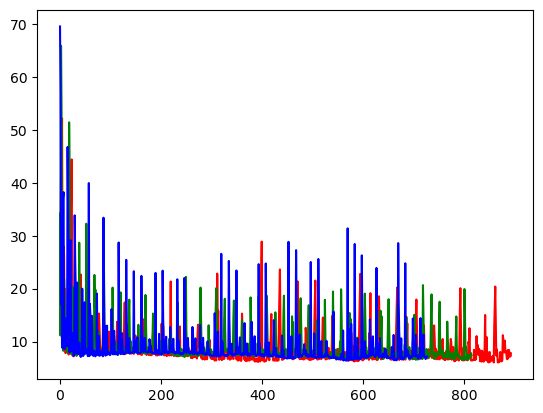

In [46]:
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(l[i], color = colors[i])

In [47]:
s.GrangerMatrix

Parameter containing:
tensor([[2.7643e-01, 4.4923e-01, 2.7433e-01],
        [2.4518e-04, 2.6888e-01, 7.3088e-01],
        [1.5876e-02, 1.1731e-01, 8.6681e-01]], requires_grad=True)

In [48]:
# s.sweep_dict

In [49]:
s.causes[0]

[tensor(1),
 tensor(2),
 tensor(0),
 tensor(1),
 tensor(1),
 tensor(2),
 tensor(2),
 tensor(2),
 tensor(0),
 tensor(0),
 tensor(1),
 tensor(0),
 tensor(2),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(2),
 tensor(0),
 tensor(2),
 tensor(1)]

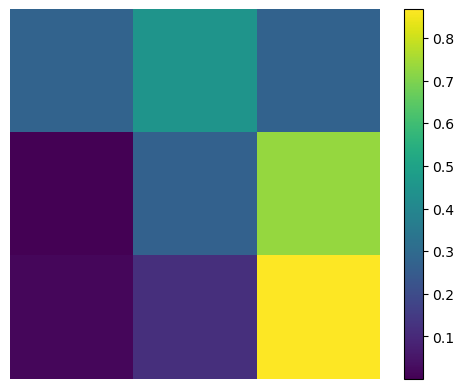

In [51]:
plt.imshow(s.GrangerMatrix.detach().cpu().numpy())
plt.axis('off')
plt.colorbar()

In [34]:
processes[0].dtype

torch.float32